## SIM Training by Stein's Method

In [1]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error

from pysim import SimRegressor

## pySIM - A python package for Sparse SIM 

**To install**:
    
```sheel
    pip install git+https://github.com/Zebinyang/pysim.git
```

Note pysim will call the R package fps (https://github.com/vqv/fps) using rpy2 interface. 

**Usage**

```python
from pysim import SimRegressor
clf = SimRegressor(method="first_order", reg_lambda=0.1, reg_gamma=10, knot_num=20, degree=2, random_state=0)
## clf.fit(x, y)
```

**Hyperparameters**

- method: the base method for estimating the projection coefficients in sparse SIM. default="first_order"

        "first_order": First-order Stein's Identity via sparse PCA solver

        "second_order": Second-order Stein's Identity via sparse PCA solver

        "first_order_thres": First-order Stein's Identity via hard thresholding (A simplified verison)        
    
- reg_lambda: The regularization strength of sparsity of beta. default=0.1, from 0 to 1 

- reg_gamma: The regularization strength of the spline algorithm. default=10, from 0 to $+\infty$

- degree: The order of the spline basis. default=2

- knot_num: The number of knots spanned uniformly over the domain. default=20

- random_state: the random seed. default=0

# Case 1: Sine Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = \sin{(u\pi)} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [2]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)

The best hyperparameter combination can be selected via cross-validation

In [3]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.05, 0.1, 0.2], 
              "reg_gamma": np.logspace(-1, 1, 3)}
grid = GridSearchCV(SimRegressor(degree=2, knot_num=20, random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  54 | elapsed:   12.2s remaining:   47.6s
[Parallel(n_jobs=-1)]: Done  39 out of  54 | elapsed:   17.5s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   18.5s finished


CPU times: user 2.02 s, sys: 6.24 s, total: 8.26 s
Wall time: 18.8 s


In [4]:
grid.best_params_

{'method': 'second_order', 'reg_gamma': 0.1, 'reg_lambda': 0.05}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [5]:
clf = grid.best_estimator_
clf

SimRegressor(degree=2, knot_num=20, method='second_order', random_state=0,
             reg_gamma=0.1, reg_lambda=0.05)

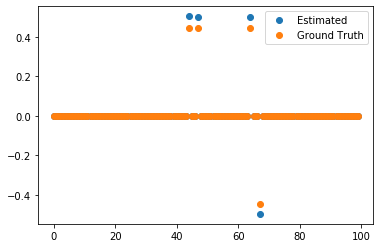

In [7]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

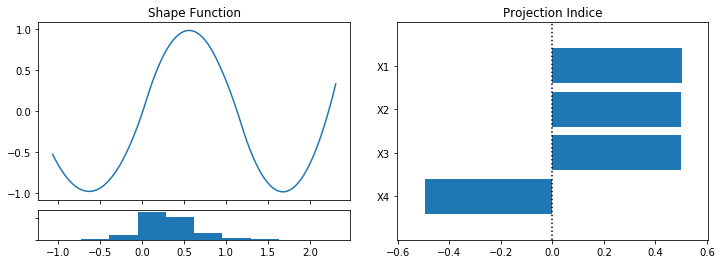

In [8]:
clf.visualize()
plt.show()

## Case 2: Quadratic Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = u^{2} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [9]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.dot(x, beta) ** 2 + np.random.randn(n_samples)

In [10]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.02, 0.05, 0.1], 
              "reg_gamma": np.logspace(-2, 2, 5)}
grid = GridSearchCV(SimRegressor(degree=2, knot_num=20, random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  90 | elapsed:    5.4s remaining:   48.8s
[Parallel(n_jobs=-1)]: Done  55 out of  90 | elapsed:   11.9s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   19.5s finished


CPU times: user 6.58 s, sys: 15.1 s, total: 21.7 s
Wall time: 19.9 s


In [11]:
grid.best_params_

{'method': 'second_order', 'reg_gamma': 1.0, 'reg_lambda': 0.02}

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [12]:
clf = grid.best_estimator_
clf

SimRegressor(degree=2, knot_num=20, method='second_order', random_state=0,
             reg_gamma=1.0, reg_lambda=0.02)

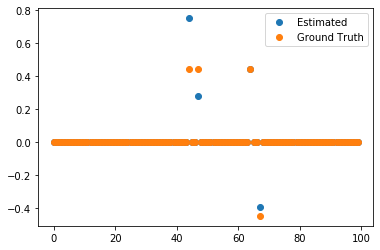

In [13]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

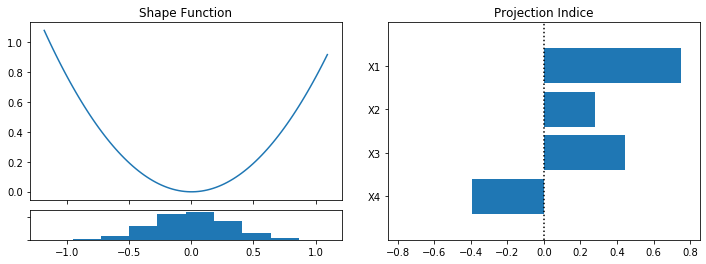

In [14]:
clf.visualize()

## Case 3: Improve a rough estimator with inner update

In [16]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.gamma(1, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)

In [23]:
%%time 

clf = SimRegressor(degree=2, knot_num=20, reg_lambda=0.01, random_state=0)
clf.fit(x, y)

CPU times: user 3.91 s, sys: 9.06 s, total: 13 s
Wall time: 328 ms


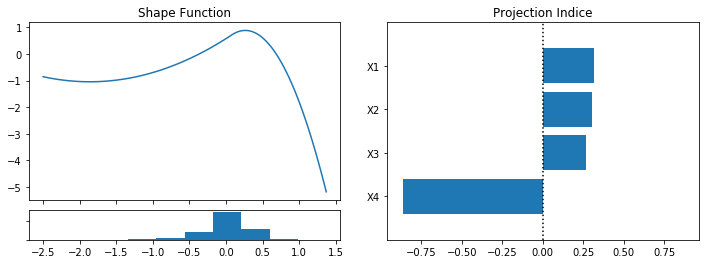

In [24]:
clf.visualize()

**Remark**：The data does not follow a normal distribution, so the performance is relatively poor.

In [25]:
clf.fit_inner_update(x, y, max_inner_iter=10, epoches=10, n_iter_no_change=1,
                     batch_size=100, val_ratio=0.2, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, verbose=True)

Inner iter: 0 epoch: 0 with validation loss: 0.05662
Inner iter: 0 epoch: 1 with validation loss: 0.05033
Inner iter: 0 epoch: 2 with validation loss: 0.04912
Inner iter: 0 epoch: 3 with validation loss: 0.04686
Inner iter: 0 epoch: 4 with validation loss: 0.04641
Inner iter: 0 epoch: 5 with validation loss: 0.04609
Inner iter: 0 epoch: 6 with validation loss: 0.04641
Inner iter: 0 epoch: 7 with validation loss: 0.04684
Inner iter: 0 epoch: 8 with validation loss: 0.04636
Inner iter: 0 epoch: 9 with validation loss: 0.04691
Inner iter: 1 epoch: 0 with validation loss: 0.02971
Inner iter: 1 epoch: 1 with validation loss: 0.02863
Inner iter: 1 epoch: 2 with validation loss: 0.02821
Inner iter: 2 epoch: 0 with validation loss: 0.04035
Inner iter: 2 epoch: 1 with validation loss: 0.03583
Inner iter: 2 epoch: 2 with validation loss: 0.03408
Inner iter: 2 epoch: 3 with validation loss: 0.03352
Inner iter: 2 epoch: 4 with validation loss: 0.03403
Inner iter: 2 epoch: 5 with validation loss: 0

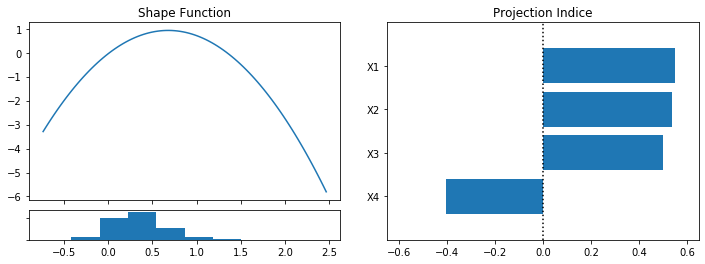

In [26]:
clf.visualize()